In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import correlate
from scipy.signal import coherence

# Data analysis

## FFT

In [2]:
# Read input
df = pd.read_csv("TEAM-02-8074-01-JAN-2020_slev.csv", skiprows=7, index_col=False)

In [3]:
subset = df[1176:1176+30*24]

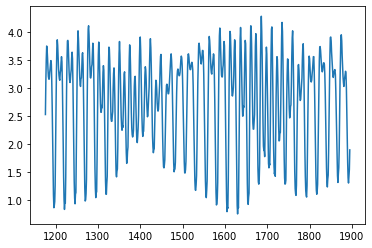

In [4]:
# Visualize actual tide signal in time domain
plt.plot(subset["SLEV(metres)"])
plt.show()

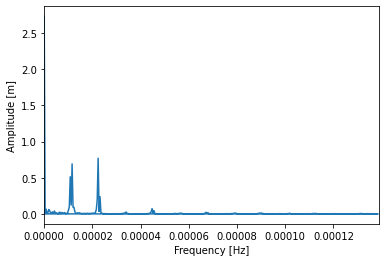

In [5]:
# Perform FFT and visualize output
data = subset["SLEV(metres)"].astype(float).values
N = data.shape[0] #number of elements
fs = 1/3600 #sampling frequency: every hour

fft = np.fft.fft(data)
fftfreq = np.fft.fftfreq(len(data), d=1/fs)
magnitude = np.insert(2*np.abs(fft[1:])/N, 0, np.abs(fft[0])/N)
phase = np.angle(fft)

plt.ylabel("Amplitude [m]")
plt.xlabel("Frequency [Hz]")
plt.plot(fftfreq,magnitude)
plt.xlim(0,fs/2)

plt.show()

In [6]:
fft_df = pd.DataFrame(data={"freq [Hz]":fftfreq, "amplitude [m]":magnitude, "phase [rad]":phase})
fft_df = fft_df[fft_df["freq [Hz]"] >= 0]
fft_df

,freq [Hz],amplitude [m],phase [rad]
0,0.000000e+00,2.731667,0.000000
1,3.858025e-07,0.010261,-2.930536
2,7.716049e-07,0.066879,0.173742
3,1.157407e-06,0.007146,0.949640
4,1.543210e-06,0.019634,-2.902598
...,...,...,...
355,1.369599e-04,0.001251,-0.293008
356,1.373457e-04,0.001108,-0.044537
357,1.377315e-04,0.001269,0.156727
358,1.381173e-04,0.001376,2.524599


In [7]:
# Arrange FFT output with descending importance order
fft_df = fft_df.sort_values(by="amplitude [m]", ascending=False)
fft_df[:10]

,freq [Hz],amplitude [m],phase [rad]
0,0.000000,2.731667,0.000000
58,0.000022,0.769523,-0.634850
30,0.000012,0.691116,-1.983191
28,0.000011,0.513861,-1.759075
60,0.000023,0.238455,-2.886824
57,0.000022,0.191085,-2.361095
29,0.000011,0.122828,-2.151123
27,0.000010,0.098272,2.174160
31,0.000012,0.092413,1.103945
32,0.000012,0.090408,1.321099


In [8]:
fft_df["period [h]"] = 1/(fft_df["freq [Hz]"])/3600
fft_df[:11]

,freq [Hz],amplitude [m],phase [rad],period [h]
0,0.000000,2.731667,0.000000,inf
58,0.000022,0.769523,-0.634850,12.413793
30,0.000012,0.691116,-1.983191,24.000000
28,0.000011,0.513861,-1.759075,25.714286
60,0.000023,0.238455,-2.886824,12.000000
57,0.000022,0.191085,-2.361095,12.631579
29,0.000011,0.122828,-2.151123,24.827586
27,0.000010,0.098272,2.174160,26.666667
31,0.000012,0.092413,1.103945,23.225806
32,0.000012,0.090408,1.321099,22.500000


Check if the frequencies make sense: https://geo.libretexts.org/Bookshelves/Oceanography/Coastal_Dynamics_(Bosboom_and_Stive)/03%3A_Ocean_waves/3.07%3A_Generation_of_the_tide/3.7.6%3A_Tidal_constituents

In [9]:
# Get the 10 most important components using FFT
num_components = 10
primary_components = fft_df[1:num_components+1]
primary_components = primary_components.reset_index(drop=True)
primary_components

,freq [Hz],amplitude [m],phase [rad],period [h]
0,0.000022,0.769523,-0.634850,12.413793
1,0.000012,0.691116,-1.983191,24.000000
2,0.000011,0.513861,-1.759075,25.714286
3,0.000023,0.238455,-2.886824,12.000000
4,0.000022,0.191085,-2.361095,12.631579
5,0.000011,0.122828,-2.151123,24.827586
6,0.000010,0.098272,2.174160,26.666667
7,0.000012,0.092413,1.103945,23.225806
8,0.000012,0.090408,1.321099,22.500000
9,0.000045,0.074022,-0.987684,6.206897


In [10]:
num_components = 3
primary_components = fft_df[1:num_components+1]
primary_components = primary_components.reset_index(drop=True)
primary_components

,freq [Hz],amplitude [m],phase [rad],period [h]
0,0.000022,0.769523,-0.634850,12.413793
1,0.000012,0.691116,-1.983191,24.000000
2,0.000011,0.513861,-1.759075,25.714286


In [11]:
# Get the freq, amp, phase of FFT to input into the tide machine
day_shift = 30
num_days = 7

primary_components["period [h]"] = 1/(primary_components["freq [Hz]"])/3600
for i in range(primary_components.shape[0]):
    f = primary_components["freq [Hz]"][i]
    a = primary_components["amplitude [m]"][i]
    primary_components["phase [rad]"][i] = primary_components["phase [rad]"][i]+2*np.pi*f*day_shift*24*3600+np.pi/2
    p = primary_components["phase [rad]"][i]

    while p > 2*np.pi:
        p -= 2*np.pi

    print(i+1)
    print(f"freq (cycle/day): {f*24*3600*2}")
    print(f"amplitude (m): {a}")
    print(f"phase (pi rad): {p/np.pi}")
    print()

1
freq (cycle/day): 3.8666666666666667
amplitude (m): 0.7695232635129667
phase (pi rad): 0.29792096049795175

2
freq (cycle/day): 2.0
amplitude (m): 0.691115991391012
phase (pi rad): 1.8687307595733027

3
freq (cycle/day): 1.8666666666666667
amplitude (m): 0.5138613504128174
phase (pi rad): 1.9400690008149548



In [12]:
# This function takes the decomposed frequencies from FFT and reconstruct the signal based on the number of components specified by the user
# The function will also print out the parameters needed to operate the tide machine if verbose is true
def plot_fft(num_components, fft_df, day_shift, duration, verbose=True):
    primary_components = fft_df[1:num_components+1]
    primary_components = primary_components.reset_index(drop=True)
    dt = 60*60
    
    if verbose:
        print(f"Day shift: {day_shift}")
    for i in range(primary_components.shape[0]):
        f = primary_components["freq [Hz]"][i]
        a = primary_components["amplitude [m]"][i]
        primary_components["phase [rad]"][i] = primary_components["phase [rad]"][i]+2*np.pi*f*day_shift*24*3600
        p = primary_components["phase [rad]"][i]

        while p > 2*np.pi:
            p -= 2*np.pi

        primary_components["phase [rad]"][i] = p
        if verbose:
            print(i+1)
            print(f"freq (cycle/day): {f*24*3600*2}")
            print(f"amplitude (m): {a}")
            print(f"phase (pi rad): {p/np.pi}")
            print()

    t_arr = np.array([t*dt for t in range(int(duration*24))])
    slev_syn = np.zeros(t_arr.shape[0])

    for i in range(num_components):
        slev_syn += primary_components["amplitude [m]"][i]*np.cos(2*np.pi*primary_components["freq [Hz]"][i]*t_arr+primary_components["phase [rad]"][i])

    slev_syn += np.mean(subset["SLEV(metres)"]) #add offset

    hours = range(int(day_shift*24), int((day_shift+duration)*24))

    if verbose:
        plt.plot(hours, slev_syn, label=f"Day shift = {day_shift}")
        plt.title("FFT - shifting")
        plt.xlabel("Time (H)")
        plt.ylabel("SLEV (m)")
        plt.legend()

    return slev_syn


Day shift: 0
1
freq (cycle/day): 3.8666666666666667
amplitude (m): 0.7695232635129667
phase (pi rad): -0.20207903950210418

2
freq (cycle/day): 2.0
amplitude (m): 0.691115991391012
phase (pi rad): -0.631269240426658

3
freq (cycle/day): 1.8666666666666667
amplitude (m): 0.5138613504128174
phase (pi rad): -0.5599309991849987

Day shift: 30
1
freq (cycle/day): 3.8666666666666667
amplitude (m): 0.7695232635129667
phase (pi rad): 1.7979209604979534

2
freq (cycle/day): 2.0
amplitude (m): 0.691115991391012
phase (pi rad): 1.3687307595733045

3
freq (cycle/day): 1.8666666666666667
amplitude (m): 0.5138613504128174
phase (pi rad): 1.4400690008149566

Day shift: 32.5
1
freq (cycle/day): 3.8666666666666667
amplitude (m): 0.7695232635129667
phase (pi rad): 1.4645876271646363

2
freq (cycle/day): 2.0
amplitude (m): 0.691115991391012
phase (pi rad): 0.368730759573301

3
freq (cycle/day): 1.8666666666666667
amplitude (m): 0.5138613504128174
phase (pi rad): 0.106735667481627

Day shift: 35
1
freq (c

array([1.3605774 , 1.70215057, 2.19517535, 2.74084717, 3.23190182,
       3.57747695, 3.72372718, 3.66516958, 3.44405668, 3.13806343,
       2.83948313, 2.63122843, 2.56570144, 2.65184223, 2.85357855,
       3.10000766, 3.30467077, 3.38897825, 3.30378896, 3.04360395,
       2.64968996, 2.20123588, 1.79666464, 1.52971729, 1.46626531,
       1.62765664, 1.98479293, 2.46447407, 2.96649432, 3.38729756,
       3.64436624, 3.6953394 , 3.54717321, 3.25314406, 2.89852546,
       2.57858808, 2.37447171, 2.33298387, 2.45536892, 2.69781671,
       2.98351586, 3.22314596, 3.33857804, 3.28374549, 3.0573617 ,
       2.70421603, 2.30465967, 1.95487506, 1.74285641, 1.72612787,
       1.91681332, 2.27784857, 2.73134889, 3.17710846, 3.51667303,
       3.67702917, 3.62804335, 3.38933955, 3.02493659, 2.62701656])

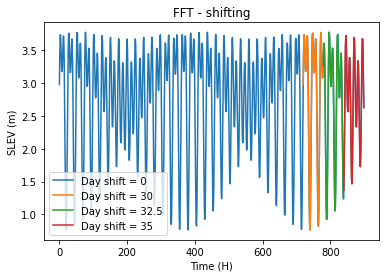

In [13]:
plot_fft(3, fft_df, 0, 37.5)
plot_fft(3, fft_df, 30, 2.5)
plot_fft(3, fft_df, 32.5, 2.5)
plot_fft(3, fft_df, 35, 2.5)

## Lord Kelvin
https://www.youtube.com/watch?v=IgF3OX8nT0w

In [14]:
# Read input
df = pd.read_csv("TEAM-02-8074-01-JAN-2020_slev.csv", skiprows=7, index_col=False)

In [15]:
period = [12.4206012,12.65834751,25.81933871,12.19162085,6.210300601,12,23.93447213,11.96723606,24.06588766,6.103339275, 26.87, 24] #unit: h, [M2, N2, O1, L2, M4, S2, K1, K2, P1, MS4]

dt = 60*60
freq = [1/(p*3600) for p in period]

window_size = 37*24
batches = int(np.floor(df.shape[0]/37))

best_mse = 100

# Grid search algorithm used to find the best duration -- the best identified duration is used for analysis
for start_ind in range(0, df.shape[0]-window_size, 7*24):
    sin_coef_list = []
    cos_coef_list = []

    subset = df[start_ind:start_ind+window_size]
    t_arr = np.array([t*dt for t in range(subset.shape[0])])
    T = (subset.shape[0]-1)*dt

    data = list(subset["SLEV(metres)"][:30*24] - np.mean(subset["SLEV(metres)"][:30*24]))

    for i in range(len(freq)):
        cos = np.cos(2*np.pi*freq[i]*t_arr[:30*24])
        a = np.sum(data*cos)/T*dt
        cos_coef_list.append(a)
        sin = np.sin(2*np.pi*freq[i]*t_arr[:30*24])
        b = np.sum(data*sin)/T*dt
        sin_coef_list.append(b)

    magnitude = [np.sqrt(a**2 + b**2) for a, b in zip(cos_coef_list, sin_coef_list)]
    phase = [np.arctan(b/a) for a, b in zip(cos_coef_list, sin_coef_list)]

    LK_df = pd.DataFrame(data={"freq [Hz]":freq, "amplitude [m]":magnitude, "phase [rad]":phase})
    LK_df["period [h]"] = 1/(LK_df["freq [Hz]"])/3600
    LK_df = LK_df.sort_values(by="amplitude [m]", ascending=False).reset_index(drop=True)

    num_components = 3
    slev_syn = np.zeros(subset.shape[0])

    for i in range(num_components):
        slev_syn += LK_df["amplitude [m]"][i]*np.sin(2*np.pi*LK_df["freq [Hz]"][i]*t_arr+LK_df["phase [rad]"][i])

    slev_syn += np.mean(subset["SLEV(metres)"]) #add offset

    mse = np.mean((subset["SLEV(metres)"][-7*24:]-slev_syn[-7*24:])**2)

    if mse < best_mse:
        best_mse = mse
        best_start_ind = start_ind
    print(f"start_ind: {start_ind} MSE: {mse}")

print(f"Best start_ind: {best_start_ind} Best MSE: {best_mse}")

start_ind: 0 MSE: 0.29294190050118907
start_ind: 168 MSE: 0.9849986206089119
start_ind: 336 MSE: 0.3911437706719772
start_ind: 504 MSE: 0.5313493194813496
start_ind: 672 MSE: 0.38981095703668106
start_ind: 840 MSE: 0.45696374258186345
start_ind: 1008 MSE: 0.8367065337933061
start_ind: 1176 MSE: 0.23764806913795614
start_ind: 1344 MSE: 0.8412684403089042
start_ind: 1512 MSE: 0.7573737440504189
start_ind: 1680 MSE: 0.8899844368339167
start_ind: 1848 MSE: 0.4121920245298114
start_ind: 2016 MSE: 0.35742914280383103
start_ind: 2184 MSE: 0.8181202412440769
start_ind: 2352 MSE: 0.5215732868222945
start_ind: 2520 MSE: 0.5346795775434412
start_ind: 2688 MSE: 1.0937060671201153
start_ind: 2856 MSE: 0.8382452419394839
start_ind: 3024 MSE: 0.7686645208532733
start_ind: 3192 MSE: 0.6811335783505924
start_ind: 3360 MSE: 0.8834776129687152
start_ind: 3528 MSE: 0.9064028053488864
start_ind: 3696 MSE: 0.8149612724599008
start_ind: 3864 MSE: 0.8227875949335167
start_ind: 4032 MSE: 1.0739203598763545
sta

In [16]:
# Get the freq, amp, phase using the best window identified
period = [12.4206012,12.65834751,25.81933871,12.19162085,6.210300601,12,23.93447213,11.96723606,24.06588766,6.103339275, 26.87, 24] #unit: h, [M2, N2, O1, L2, M4, S2, K1, K2, P1, MS4]
dt = 60*60
freq = [1/(p*3600) for p in period]

sin_coef_list = []
cos_coef_list = []

start_ind = 1176
window_size = 30*24

subset = df[start_ind:start_ind+window_size]
t_arr = np.array([t*dt for t in range(subset.shape[0])])
T = (subset.shape[0]-1)*dt

data = list(subset["SLEV(metres)"] - np.mean(subset["SLEV(metres)"]))

for i in range(len(freq)):
    cos = np.cos(2*np.pi*freq[i]*t_arr)
    a = np.sum(data*cos)/T*dt
    cos_coef_list.append(a)
    sin = np.sin(2*np.pi*freq[i]*t_arr)
    b = np.sum(data*sin)/T*dt
    sin_coef_list.append(b)

magnitude = [np.sqrt(a**2 + b**2) for a, b in zip(cos_coef_list, sin_coef_list)]
phase = [np.arctan(b/a) for a, b in zip(cos_coef_list, sin_coef_list)]


In [37]:
LK_df = pd.DataFrame(data={"freq [Hz]":freq, "amplitude [m]":magnitude, "phase [rad]":phase})
LK_df["period [h]"] = 1/(LK_df["freq [Hz]"])/3600
LK_df

,freq [Hz],amplitude [m],phase [rad],period [h]
0,0.000022,0.385182,0.531971,12.420601
1,0.000022,0.101727,1.533358,12.658348
2,0.000011,0.278938,1.411746,25.819339
3,0.000023,0.033864,1.163578,12.191621
4,0.000045,0.036174,0.774392,6.210301
5,0.000023,0.119393,-0.254769,12.000000
6,0.000012,0.360625,-0.902676,23.934472
7,0.000023,0.106607,0.048857,11.967236
8,0.000012,0.322988,-1.413879,24.065888
9,0.000046,0.022793,0.183337,6.103339


In [18]:
# This function takes the decomposed frequencies using harmonic analysis and reconstruct the signal based on the number of components specified by the user
# The function will also print out the parameters needed to operate the tide machine if verbose is true
def plot_LK(num_components, freq, magnitude, phase, day_shift, duration, verbose=True):
    LK_df = pd.DataFrame(data={"freq [Hz]":freq, "amplitude [m]":magnitude, "phase [rad]":phase})
    LK_df["period [h]"] = 1/(LK_df["freq [Hz]"])/3600
    LK_df = LK_df.sort_values(by="amplitude [m]", ascending=False).reset_index(drop=True)

    primary_components = LK_df[:num_components]
    dt = 60*60

    if verbose:
        print(f"Day shift: {day_shift}")
    for i in range(primary_components.shape[0]):
        f = primary_components["freq [Hz]"][i]
        a = primary_components["amplitude [m]"][i]
        primary_components["phase [rad]"][i] = primary_components["phase [rad]"][i]+2*np.pi*f*day_shift*24*3600-np.pi/2
        p = primary_components["phase [rad]"][i]

        while p > 2*np.pi:
            p -= 2*np.pi

        primary_components["phase [rad]"][i] = p

        if verbose:
            print(i+1)
            print(f"freq (cycle/day): {f*24*3600*2}")
            print(f"amplitude (m): {a}")
            print(f"phase (pi rad): {p/np.pi}")
            print()

    t_arr = np.array([t*dt for t in range(int(duration*24))])
    slev_syn = np.zeros(t_arr.shape[0])

    for i in range(num_components):
        slev_syn += primary_components["amplitude [m]"][i]*np.cos(2*np.pi*primary_components["freq [Hz]"][i]*t_arr+primary_components["phase [rad]"][i])

    slev_syn += np.mean(subset["SLEV(metres)"]) #add offset

    hours = range(int(day_shift*24), int((day_shift+duration)*24))

    if verbose:
        plt.plot(hours, slev_syn, label=f"Day shift = {day_shift}")
        plt.title("LK - shifting")
        plt.xlabel("Time (H)")
        plt.ylabel("SLEV (m)")
        plt.legend()

    return slev_syn


Day shift: 0
1
freq (cycle/day): 3.864547233027657
amplitude (m): 0.3851822882634674
phase (pi rad): -0.33066828084476174

2
freq (cycle/day): 2.0054756060333467
amplitude (m): 0.3606245083166853
phase (pi rad): -0.7873306705890923

3
freq (cycle/day): 2.0
amplitude (m): 0.34603860486893473
phase (pi rad): -0.8687307595733437

Day shift: 30
1
freq (cycle/day): 3.864547233027657
amplitude (m): 0.3851822882634674
phase (pi rad): 1.6057487099849856

2
freq (cycle/day): 2.0054756060333467
amplitude (m): 0.3606245083166853
phase (pi rad): 1.3769375104112695

3
freq (cycle/day): 2.0
amplitude (m): 0.34603860486893473
phase (pi rad): 1.1312692404266238

Day shift: 32.5
1
freq (cycle/day): 3.864547233027657
amplitude (m): 0.3851822882634674
phase (pi rad): 1.2671167925541391

2
freq (cycle/day): 2.0054756060333467
amplitude (m): 0.3606245083166853
phase (pi rad): 0.3906265254946363

3
freq (cycle/day): 2.0
amplitude (m): 0.34603860486893473
phase (pi rad): 0.13126924042662041

Day shift: 35
1


C:\Users\qitia\AppData\Local\Temp\ipykernel_31472\1936928424.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primary_components["phase [rad]"][i] = primary_components["phase [rad]"][i]+2*np.pi*f*day_shift*24*3600-np.pi/2
C:\Users\qitia\AppData\Local\Temp\ipykernel_31472\1936928424.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primary_components["phase [rad]"][i] = p
C:\Users\qitia\AppData\Local\Temp\ipykernel_31472\1936928424.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

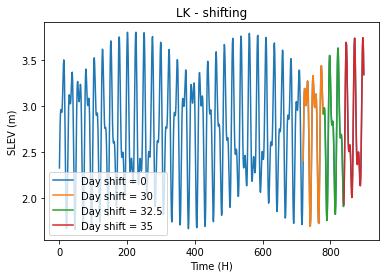

In [19]:
plot_LK(3, freq, magnitude, phase, 0, 37.5)
a1 = plot_LK(3, freq, magnitude, phase, 30, 2.5)
a2 = plot_LK(3, freq, magnitude, phase, 32.5, 2.5)
a3 = plot_LK(3, freq, magnitude, phase, 35, 2.5)


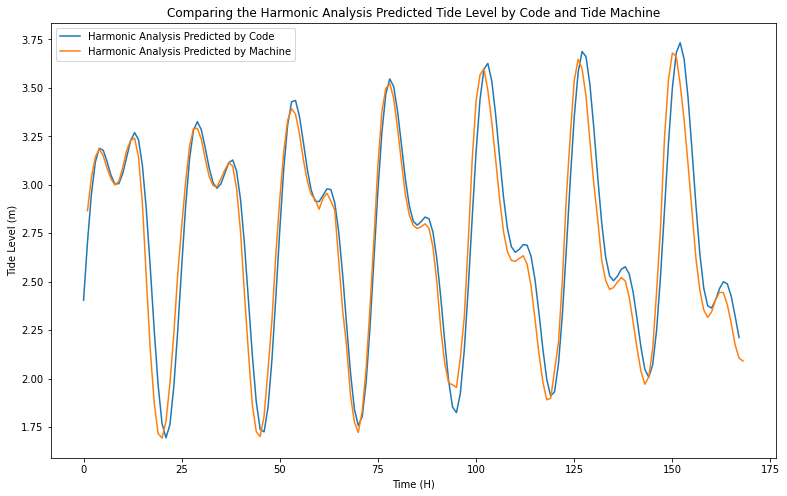

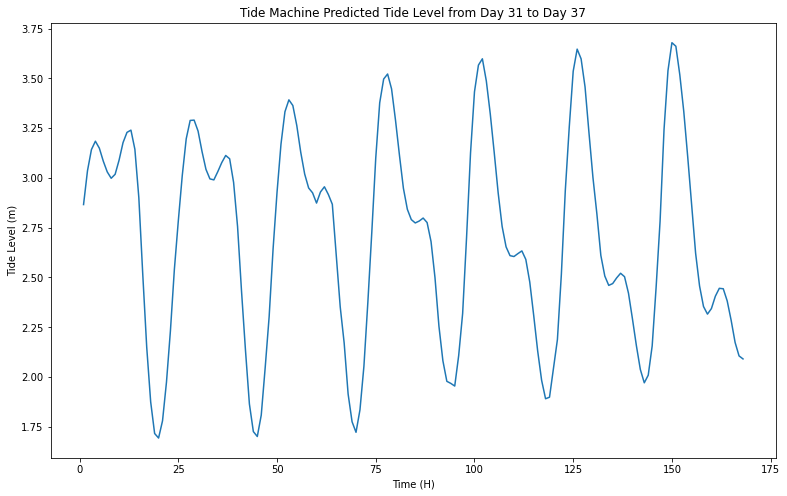

In [38]:
# compare harmonic analysis method created by computer and by tide machine
LKTide = np.concatenate((a1, a2, a3))
LKTide = LKTide[0:168]
SevenDay = np.arange(0, 168)

df2 = pd.read_csv('TideMachineData.csv', header=None)

predTideHours = df2.iloc[:, 0]  
predTide = df2.iloc[:, 1]  

predTidePeak = np.max(predTide)
predTide = 2*predTidePeak - predTide; 

predTide = predTide - 2.01

plt.figure(figsize=(13,8))
plt.plot(SevenDay, LKTide, label='Harmonic Analysis Predicted by Code')
plt.plot(predTideHours, predTide, label='Harmonic Analysis Predicted by Machine')
plt.legend()
plt.title("Comparing the Harmonic Analysis Predicted Tide Level by Code and Tide Machine")
plt.xlabel("Time (H)")
plt.ylabel("Tide Level (m)")
plt.show()


plt.figure(figsize=(13,8))
plt.plot(predTideHours, predTide)
plt.title("Tide Machine Predicted Tide Level from Day 31 to Day 37")
plt.xlabel("Time (H)")
plt.ylabel("Tide Level (m)")
plt.show()


# Predictions

In [21]:
def get_mse(actual, predicted):
    return np.mean((actual-predicted)**2)

def get_nse(actual, predicted):
    return 1-np.sum((actual-predicted)**2/np.sum(actual-np.mean(actual))**2)

In [22]:
actual_slev = df[1176+30*24:1176+37*24]["SLEV(metres)"]

## FFT

In [23]:
fft_df

,freq [Hz],amplitude [m],phase [rad],period [h]
0,0.000000,2.731667,0.000000,inf
58,0.000022,0.769523,-0.634850,12.413793
30,0.000012,0.691116,-1.983191,24.000000
28,0.000011,0.513861,-1.759075,25.714286
60,0.000023,0.238455,-2.886824,12.000000
...,...,...,...,...
134,0.000052,0.000240,-1.599742,5.373134
333,0.000128,0.000151,-0.526224,2.162162
245,0.000095,0.000145,-2.268480,2.938776
272,0.000105,0.000127,0.158541,2.647059


In [24]:
# Iteratively reconstruct predictions using different number of components
num_components = [1, 3, 5, 7, 9]
fft_predictions = []
fft_mse = []
fft_nse = []
for num_component in num_components:
    predicted_slev = plot_fft(num_component, fft_df, 0, 37, verbose=False)
    predicted_slev = predicted_slev[30*24:] # we only want the tide predictations starting after 30 days
    fft_predictions.append(predicted_slev)
    fft_mse.append(get_mse(actual_slev, predicted_slev))
    fft_nse.append(get_nse(actual_slev, predicted_slev))

## Lord Kelvin / Harmonic analysis

In [25]:
# perform harmonic analysis using the given 10 tidal constituent period

period = [12.4206012,12.65834751,25.81933871,12.19162085,6.210300601,12,23.93447213,11.96723606,24.06588766,6.103339275, 26.87, 24] #unit: h, [M2, N2, O1, L2, M4, S2, K1, K2, P1, MS4]
dt = 60*60
freq = [1/(p*3600) for p in period]

sin_coef_list = []
cos_coef_list = []

start_ind = 1176
window_size = 30*24

subset = df[start_ind:start_ind+window_size]
t_arr = np.array([t*dt for t in range(subset.shape[0])])
T = (subset.shape[0]-1)*dt

data = list(subset["SLEV(metres)"] - np.mean(subset["SLEV(metres)"]))

for i in range(len(freq)):
    cos = np.cos(2*np.pi*freq[i]*t_arr)
    a = np.sum(data*cos)/T*dt
    cos_coef_list.append(a)
    sin = np.sin(2*np.pi*freq[i]*t_arr)
    b = np.sum(data*sin)/T*dt
    sin_coef_list.append(b)

magnitude = [np.sqrt(a**2 + b**2) for a, b in zip(cos_coef_list, sin_coef_list)]
phase = [np.arctan(b/a) for a, b in zip(cos_coef_list, sin_coef_list)]

In [26]:
LK_df = pd.DataFrame(data={"freq [Hz]":freq, "amplitude [m]":magnitude, "phase [rad]":phase})
LK_df["period [h]"] = 1/(LK_df["freq [Hz]"])/3600
LK_df = LK_df.sort_values(by="amplitude [m]", ascending=False).reset_index(drop=True)
LK_df

,freq [Hz],amplitude [m],phase [rad],period [h]
0,0.000022,0.385182,0.531971,12.420601
1,0.000012,0.360625,-0.902676,23.934472
2,0.000012,0.346039,-1.158402,24.000000
3,0.000012,0.322988,-1.413879,24.065888
4,0.000011,0.278938,1.411746,25.819339
5,0.000023,0.119393,-0.254769,12.000000
6,0.000023,0.106607,0.048857,11.967236
7,0.000022,0.101727,1.533358,12.658348
8,0.000010,0.056173,-1.110837,26.870000
9,0.000045,0.036174,0.774392,6.210301


In [27]:
# Iteratively reconstruct predictions using different number of components
num_components = [1, 3, 5, 7, 9]
LK_predictions = []
LK_mse = []
LK_nse = []
for num_component in num_components:
    predicted_slev = plot_LK(num_component, freq, magnitude, phase, 0, 37, verbose=False)
    predicted_slev = predicted_slev[30*24:]
    LK_predictions.append(predicted_slev)
    LK_mse.append(get_mse(actual_slev, predicted_slev))
    LK_nse.append(get_nse(actual_slev, predicted_slev))

C:\Users\qitia\AppData\Local\Temp\ipykernel_31472\1936928424.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primary_components["phase [rad]"][i] = primary_components["phase [rad]"][i]+2*np.pi*f*day_shift*24*3600-np.pi/2
C:\Users\qitia\AppData\Local\Temp\ipykernel_31472\1936928424.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primary_components["phase [rad]"][i] = p
C:\Users\qitia\AppData\Local\Temp\ipykernel_31472\1936928424.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

## Compare prediction results

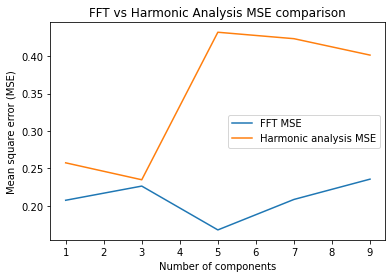

In [28]:
plt.plot(num_components, fft_mse, label="FFT MSE")
plt.plot(num_components, LK_mse, label="Harmonic analysis MSE")
plt.xlabel("Number of components")
plt.ylabel("Mean square error (MSE)")
plt.title("FFT vs Harmonic Analysis MSE comparison")
plt.legend()

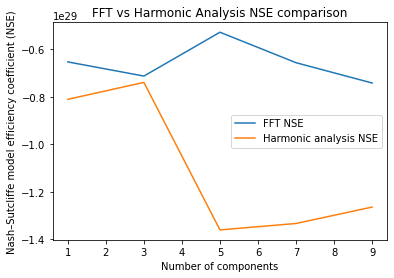

In [29]:
plt.plot(num_components, fft_nse, label="FFT NSE")
plt.plot(num_components, LK_nse, label="Harmonic analysis NSE")
plt.xlabel("Number of components")
plt.ylabel("Nash–Sutcliffe model efficiency coefficient (NSE)")
plt.title("FFT vs Harmonic Analysis NSE comparison")
plt.legend()

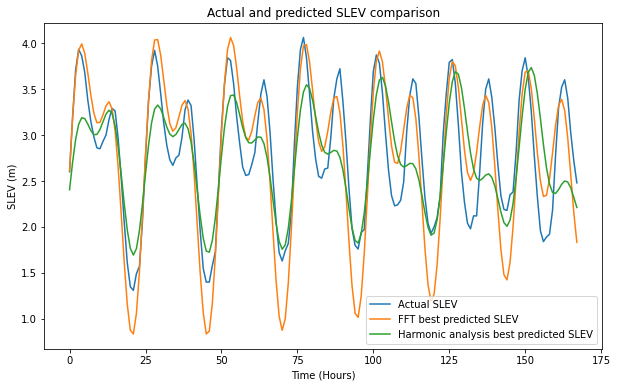

In [30]:
hours = range(7*24)
plt.figure(figsize=(10,6))
plt.plot(hours, actual_slev, label="Actual SLEV")
plt.plot(hours, fft_predictions[2], label="FFT best predicted SLEV")
plt.plot(hours, LK_predictions[1], label="Harmonic analysis best predicted SLEV")
plt.xlabel("Time (Hours)")
plt.ylabel("SLEV (m)")
plt.title("Actual and predicted SLEV comparison")
plt.legend()

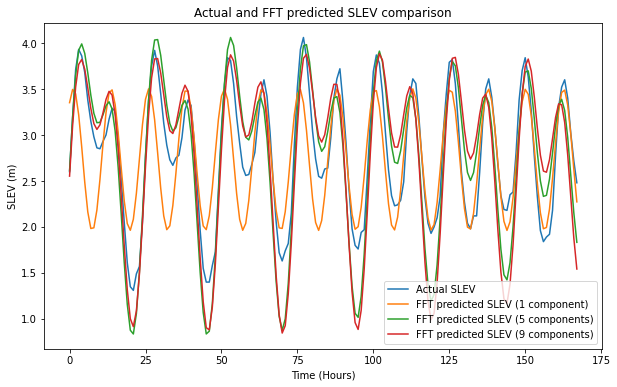

In [31]:
hours = range(7*24)
plt.figure(figsize=(10,6))
plt.plot(hours, actual_slev, label="Actual SLEV")
plt.plot(hours, fft_predictions[0], label="FFT predicted SLEV (1 component)")
# plt.plot(hours, fft_predictions[1], label="FFT predicted SLEV (3 components)")
plt.plot(hours, fft_predictions[2], label="FFT predicted SLEV (5 components)")
# plt.plot(hours, fft_predictions[3], label="FFT predicted SLEV (7 components)")
plt.plot(hours, fft_predictions[4], label="FFT predicted SLEV (9 components)")
plt.xlabel("Time (Hours)")
plt.ylabel("SLEV (m)")
plt.title("Actual and FFT predicted SLEV comparison")
plt.legend()

# Root Mean Square Error

In [32]:
actual_slev = df[1176+30*24:1176+37*24]["SLEV(metres)"]
actual_slev = actual_slev.reset_index(drop=True)

rmse_TideMachine = get_mse(actual_slev, predTide) ** 0.5
print(rmse_TideMachine)

rmseFFT = get_mse(actual_slev, fft_predictions[2]) ** 0.5
print(rmseFFT)

0.532212350829866
0.40976954923294867


# Time Domain Analysis: Cross Correlation

1316.8775021981203
1394.955061328137


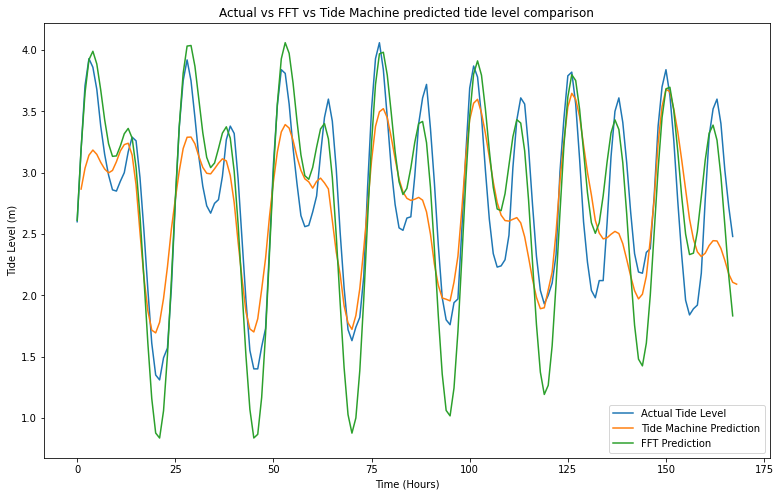

In [33]:
crossCrorrelationTideMachine = np.correlate(predTide,actual_slev,mode='full')
crossCrorrelationTideMachineMax = np.max(crossCrorrelationTideMachine) 
print(crossCrorrelationTideMachineMax)

crossCrorrelationActual = np.correlate(fft_predictions[2],actual_slev,mode='full')
crossCrorrelationActualMax = np.max(crossCrorrelationActual) 
print(crossCrorrelationActualMax)


plt.figure(figsize=(13, 8))
plt.plot(SevenDay, actual_slev, label="Actual Tide Level")
plt.plot(predTideHours, predTide, label="Tide Machine Prediction")
plt.plot(SevenDay, fft_predictions[2], label="FFT Prediction")
plt.legend()
plt.xlabel("Time (Hours)")
plt.ylabel("Tide Level (m)")
plt.title("Actual vs FFT vs Tide Machine predicted tide level comparison")
plt.show()

In [34]:
fft_df.head(6)

,freq [Hz],amplitude [m],phase [rad],period [h]
0,0.000000,2.731667,0.000000,inf
58,0.000022,0.769523,-0.634850,12.413793
30,0.000012,0.691116,-1.983191,24.000000
28,0.000011,0.513861,-1.759075,25.714286
60,0.000023,0.238455,-2.886824,12.000000
57,0.000022,0.191085,-2.361095,12.631579


In [35]:
# this function find 3 peaks in the periodogram plot

def find_peaks_in_periodogram(signal_data, fs):
    f, p = signal.periodogram(signal_data, fs)

    peaks, _ = signal.find_peaks(p)

    peak_heights = p[peaks]
    top_peaks_indices = np.argsort(peak_heights)[-3:] 
    top_peaks_frequencies = f[peaks][top_peaks_indices]
    top_peaks_magnitudes = peak_heights[top_peaks_indices]

    return list(zip(top_peaks_frequencies, top_peaks_magnitudes))

# Frequency Domain Analysis: Spectrum Coherence

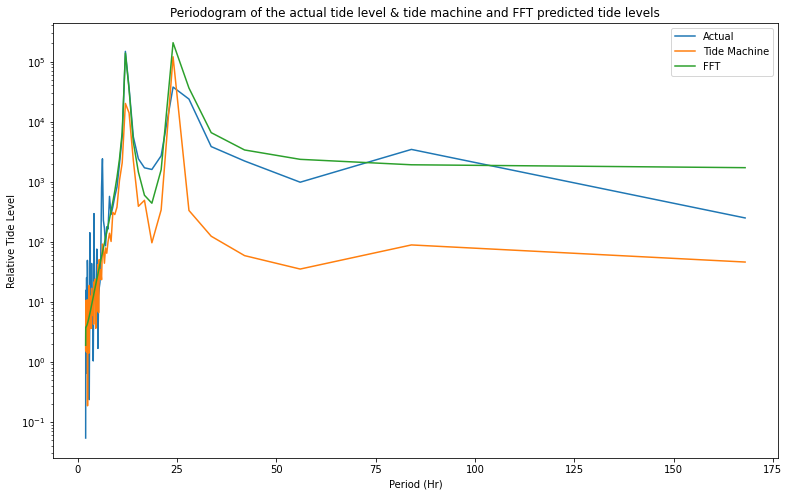

[(3.306878306878307e-06, 3437.0585079218245), (1.1574074074074075e-05, 37581.86845291879), (2.314814814814815e-05, 147633.44754856522)]
[(1.6534391534391536e-05, 487.8956388503191), (2.314814814814815e-05, 20053.276901911413), (1.1574074074074075e-05, 120060.32380155649)]


In [36]:
fs = 1/3600

f_actual, p_actual = signal.periodogram(actual_slev, fs)
f_TideMachine, p_TideMachine = signal.periodogram(predTide, fs)
f_FFT, p_FFT = signal.periodogram(fft_predictions[2], fs)


f_actual = f_actual[1:]
p_actual = p_actual[1:]
period_actual = 1 / f_actual / 3600

f_TideMachine = f_TideMachine[1:]
p_TideMachine = p_TideMachine[1:]
period_TideMachine = 1 / f_TideMachine / 3600

f_FFT = f_FFT[1:]
period_FFT = 1 / f_FFT / 3600
p_FFT = p_FFT[1:]

plt.figure(figsize=(13,8))
plt.semilogy(period_actual, p_actual, label="Actual")
plt.semilogy(period_TideMachine, p_TideMachine, label="Tide Machine")
plt.semilogy(period_FFT, p_FFT, label="FFT")
plt.legend()
plt.title("Periodogram of the actual tide level & tide machine and FFT predicted tide levels")
plt.xlabel("Period (Hr)")
plt.ylabel("Relative Tide Level")
plt.show()

peaks_actual_slev = find_peaks_in_periodogram(actual_slev, fs)
peaks_tide_machine = find_peaks_in_periodogram(predTide, fs)

print(peaks_actual_slev)
print(peaks_tide_machine)
